### Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [117]:
df = pd.read_csv('HW_data.csv')

In [118]:
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [119]:
df.rename(columns={'conversion' : 'target', 'offer':'treatment'}, inplace=True)
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [120]:
dicti = {'Buy One Get One':1,'Discount':1, 'No Offer':0}
df.replace(dicti, inplace=True)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [122]:
class ColumnSelector():

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]  

    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]    
    

In [123]:
columnsNumber=['zip_code','channel']
cat_columns = Pipeline([('select', ColumnSelector(key=columnsNumber)),
    ('categorial', OHEEncoder(key=columnsNumber))])

In [124]:
columnsNumber=['recency','history']
number_column = Pipeline([('select', ColumnSelector(key=columnsNumber)),
    ('number', StandardScaler())])

In [125]:
columnsNumber = ['used_discount','used_bogo', 'is_referral']
pass_columns = Pipeline([('select', ColumnSelector(key=columnsNumber))]) 

In [126]:
feature = make_union(cat_columns, number_column, pass_columns)

In [127]:
df_tranform = feature.fit_transform(df)

In [128]:
train_index = df.index[:48000]
test_index = df.index[16000:]

In [129]:
X_train = pd.DataFrame(df_tranform[train_index])
y_train = df.loc[train_index, 'target']
treat_train = df.loc[train_index, 'treatment']

X_test = pd.DataFrame(df_tranform[test_index])
y_test = df.loc[test_index, 'target']
treat_test = df.loc[test_index, 'treatment']

In [130]:
y_train.value_counts()

0    40940
1     7060
Name: target, dtype: int64

In [131]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, ClassTransformation, TwoModels
from catboost import CatBoostClassifier

In [132]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

uplift@10%: 0.1377
uplift@20%: 0.1268


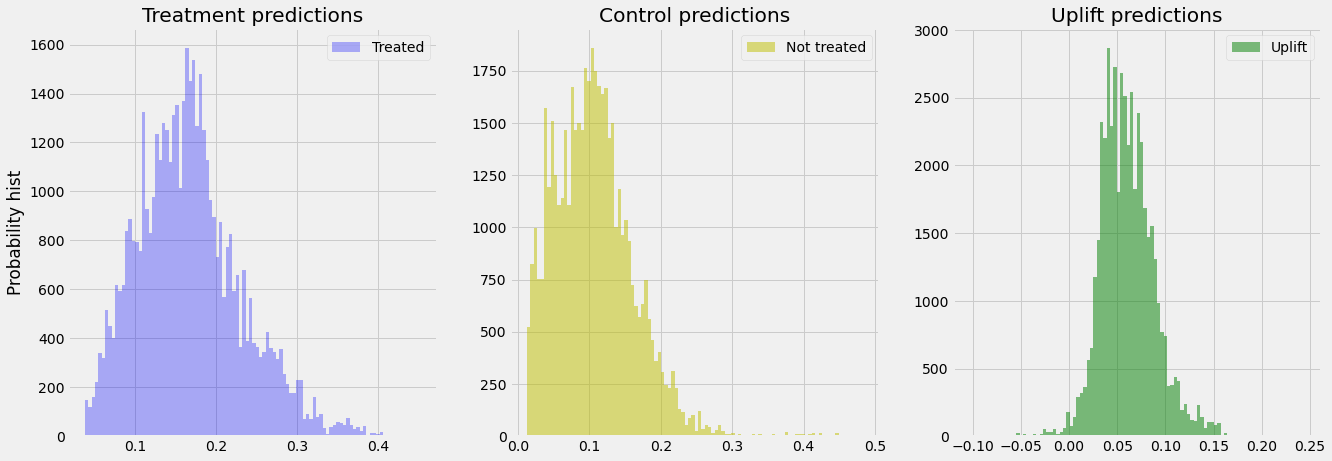

In [133]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
print(f'uplift@10%: {sm_score_10:.4f}')


sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@20%: {sm_score_20:.4f}')


models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)


# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


uplift@10%: 0.1317
uplift@20%: 0.1155


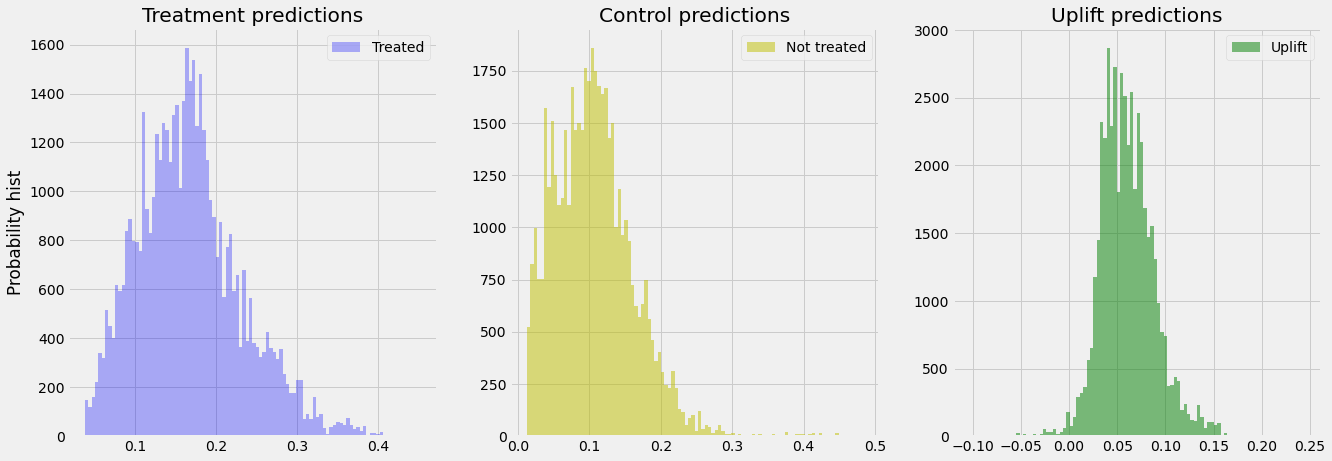

In [134]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train) 

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
print(f'uplift@10%: {ct_score_10:.4f}')
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@20%: {ct_score_20:.4f}')

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
ct_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
ct_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=ct_trmnt_preds, ctrl_preds=ct_ctrl_preds);

uplift@10%: 0.1562
uplift@10%: 0.1229


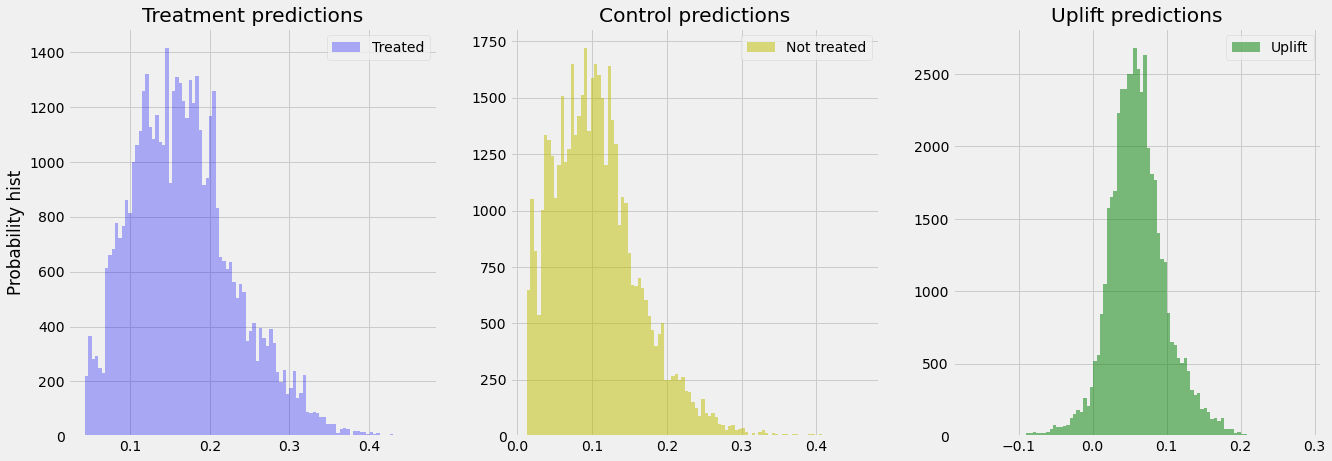

In [135]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)


tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
print(f'uplift@10%: {tm_score_10:.4f}')
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@10%: {tm_score_20:.4f}')

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)


plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [137]:
pd.DataFrame(models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.137720,0.126803
1,ClassTransformation,0.131694,0.115451
2,TwoModels,0.156183,0.122918


In [138]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot


In [141]:
uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')


features = [col for col in X_train]
uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)


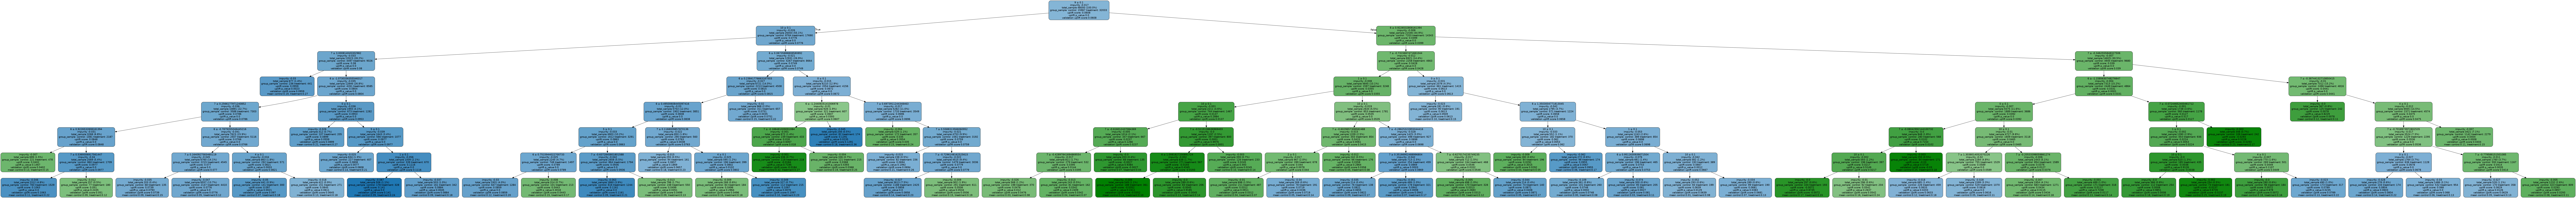

In [142]:
Image(graph.create_png())

первая строка - feature_name и критерий разбиения узла 
impurity: значение для функции потерь
total_sample: объём выборки в этом узле, листе
group_sample: разделение выборки по группам
uplift score: "тритмент" эффект в этом узле,
uplift p_value: p значение "тритмент" эффекта в этом узле,
validation uplift score: оценку можно использовать в качестве сравнения с оценкой uplift score, чтобы оценить, есть ли у дерева проблема переобучения.